In [1]:
import sys
import os

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import seaborn as sns
sns.set_style('whitegrid')

sys.path.append('../src/')

from dataset.create_data import create_dataset

# Create a full dataset using DiffMoog

Set up the parameters for the dataset generation. For more about synth presets, checkout the notebook *explore_presets.ipynb*
You can also directly use the script in *src/dataset/create_data.py*

In [23]:
# Dataset location
data_root = '../data'    # where to put created data
dataset_name = 'example_basic_flow_dataset'

dataset_dir = os.path.join(data_root, dataset_name, '')
os.makedirs(dataset_dir, exist_ok=True)

In [25]:
# Generation parameters
synth_preset = 'BASIC_FLOW'  # synth structure, one of the presets defined in synth/synth_presets.py
signal_duration = 4.0        # sound duration in seconds
note_off = 3.0               # note off time in seconds

device = 'cuda:0'
split = 'train'              # data split to create

size = 10000                  # number of sounds to generate
batch_size = 1000             # number of sounds to generate in parallel. decrease to reduce memory use

In [6]:
create_dataset(preset=synth_preset, output_dir=dataset_dir, split=split, size=size,
               signal_duration=signal_duration, note_off_time=note_off, batch_size=batch_size,
               device=device)

Creating dataset 
 Size = 10000
 Type = train 



  0%|                                                                                                                                                       | 0/10000 [00:00<?, ?it/s]

Missing amp param in Oscillator module lfo. Assuming fixed amp. Please check Synth structure if this is unexpected.
Missing amp param in Oscillator module lfo. Assuming fixed amp. Please check Synth structure if this is unexpected.
Missing amp param in Oscillator module lfo. Assuming fixed amp. Please check Synth structure if this is unexpected.


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10000/10000 [00:21<00:00, 465.90it/s]


## Visualize the parameters of the generated data

In [26]:
params_pkl_path = os.path.join(dataset_dir, split, 'params_dataset.pkl')
dataset_params_df = pd.read_pickle(params_pkl_path)

cols_to_drop = []
for col in dataset_params_df.columns:
    val = dataset_params_df[col][0]
    if val['operation'] == 'None':
        cols_to_drop.append(col)

dataset_params_df.drop(cols_to_drop, axis=1, inplace=True)

In [27]:
def visualize_params(param_column):

    op = param_column[0]['operation']
    if op == 'mix':
        return

    param_names = list(param_column[0]['parameters'].keys())

    for p in param_names:
        if 'output' in p:
            continue
        vals = [c['parameters'][p] for c in param_column]
        if type(vals[0]) in [np.bool_, bool]:
            vals = [int(v) for v in vals]
        plt.hist(vals, bins=20)
        plt.title(f"{op} {p}")
        plt.show()

    return

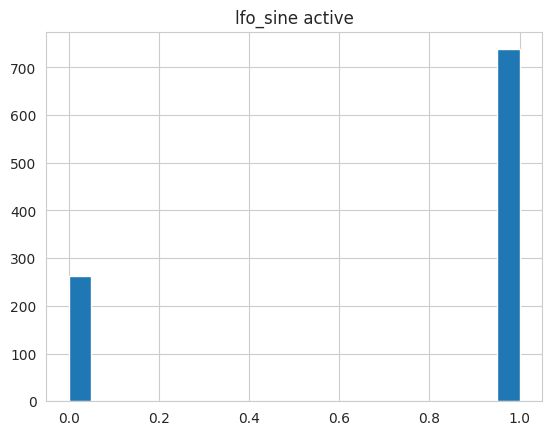

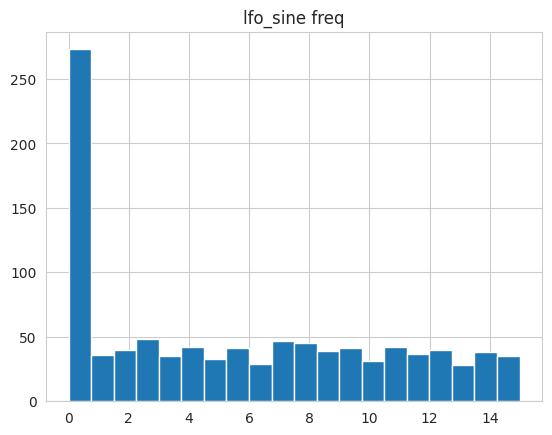

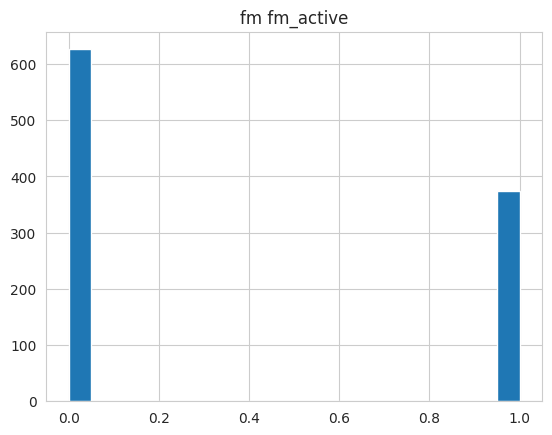

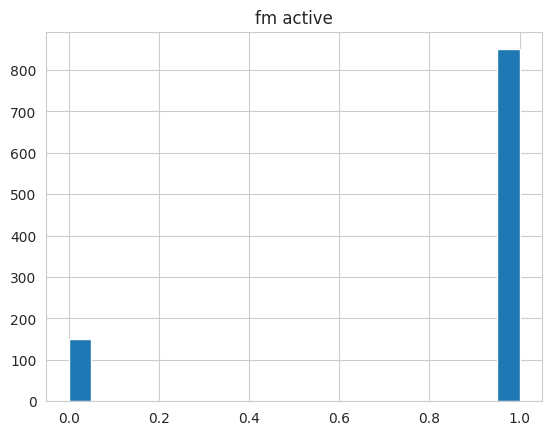

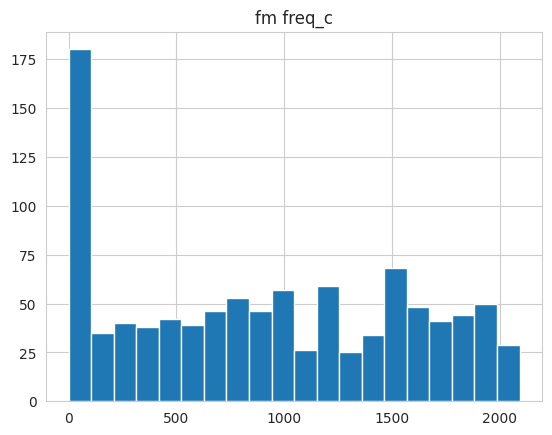

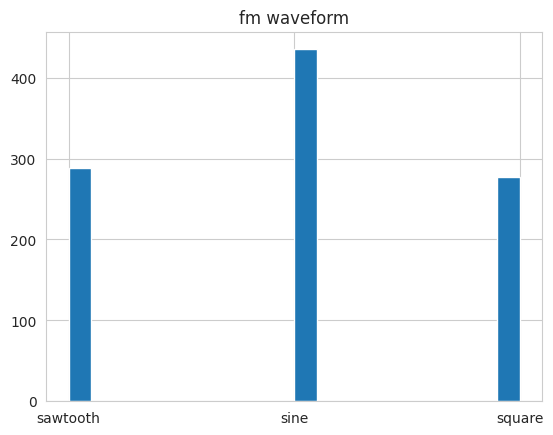

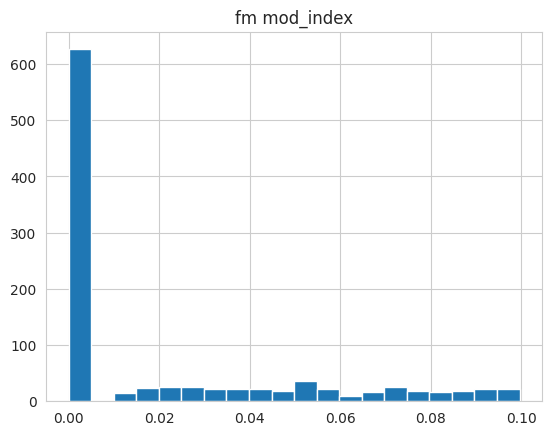

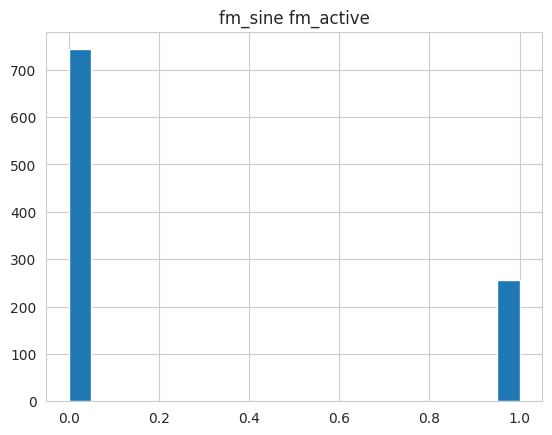

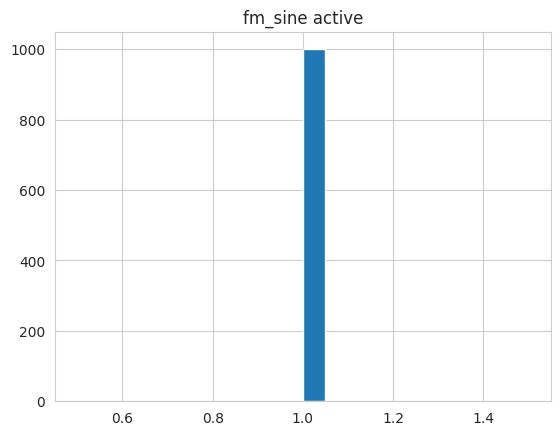

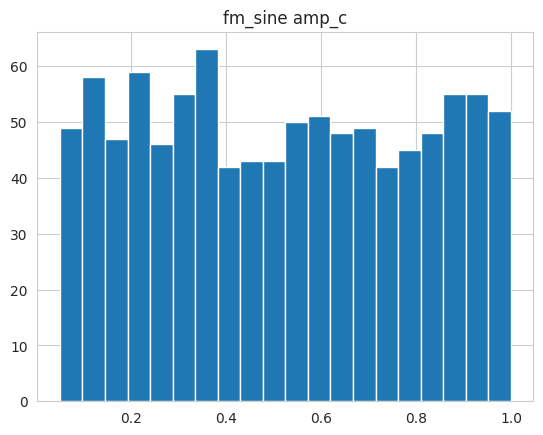

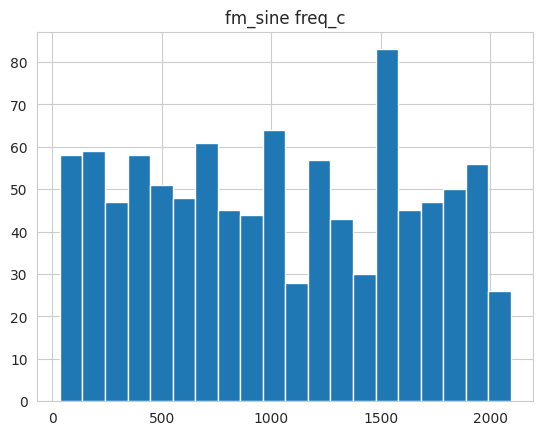

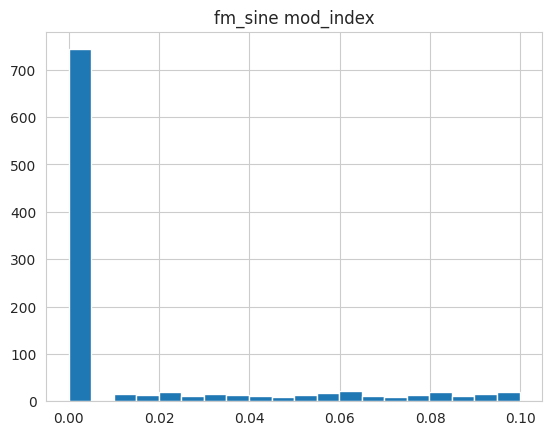

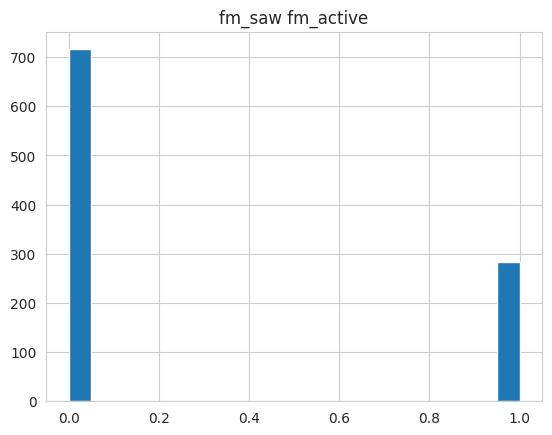

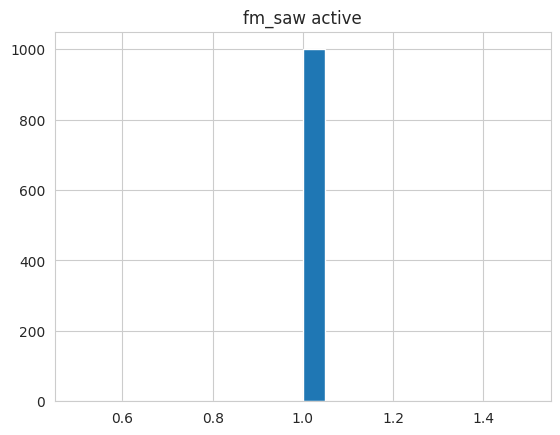

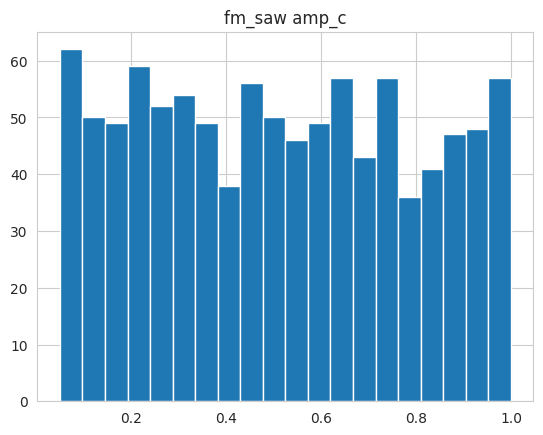

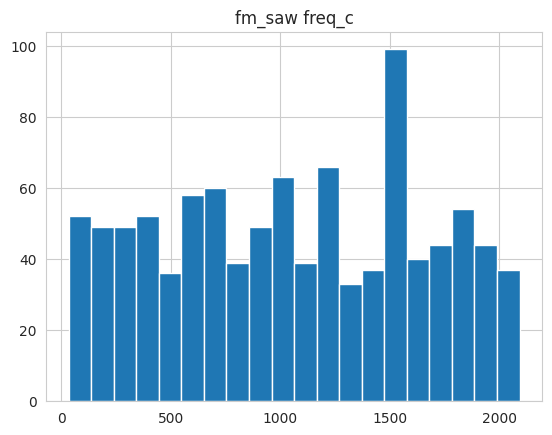

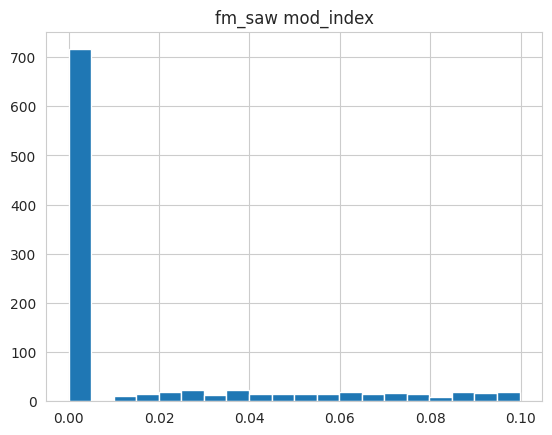

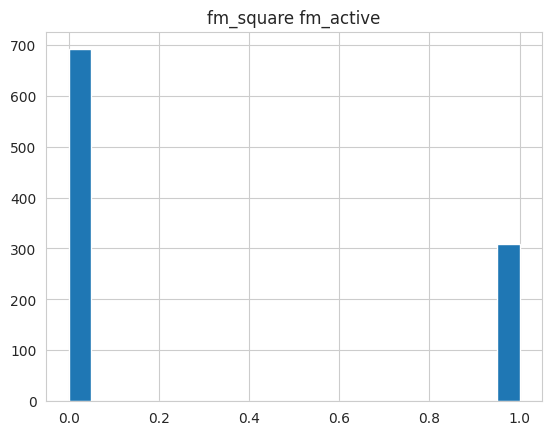

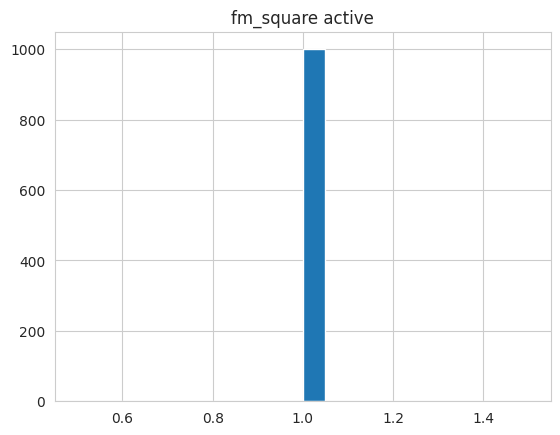

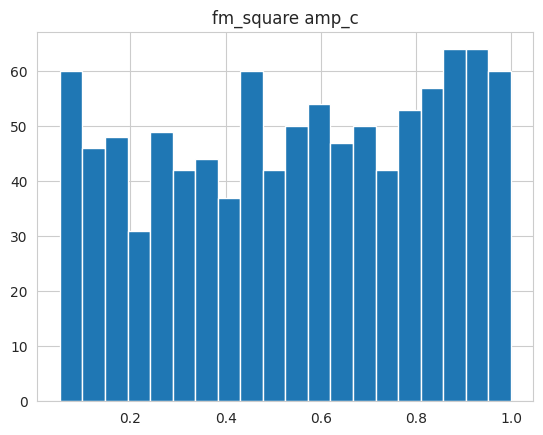

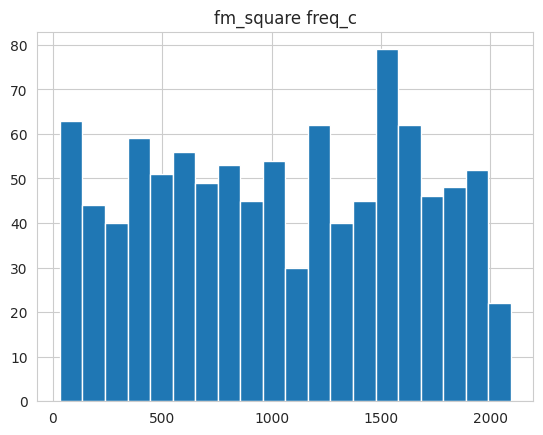

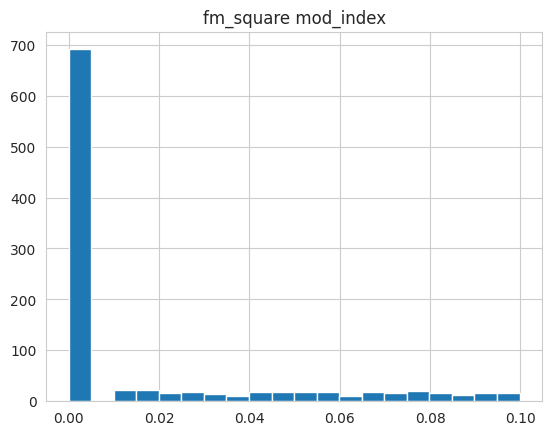

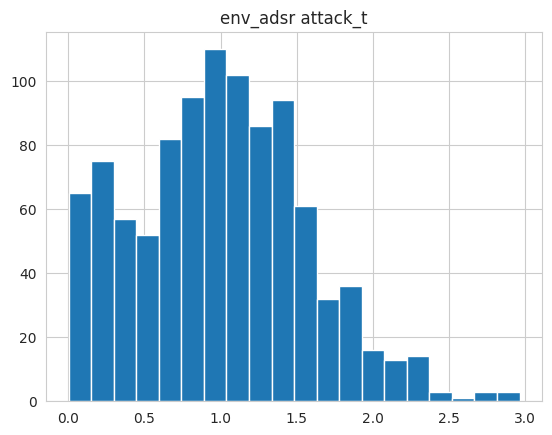

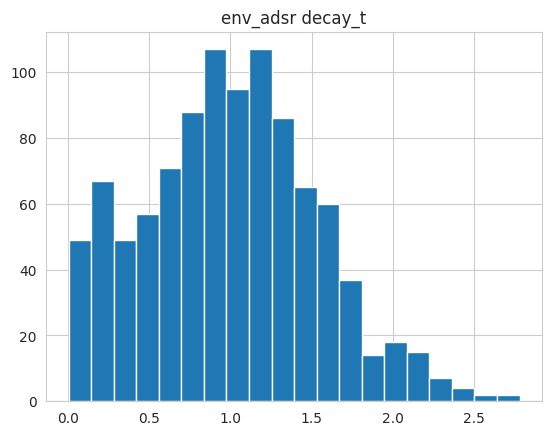

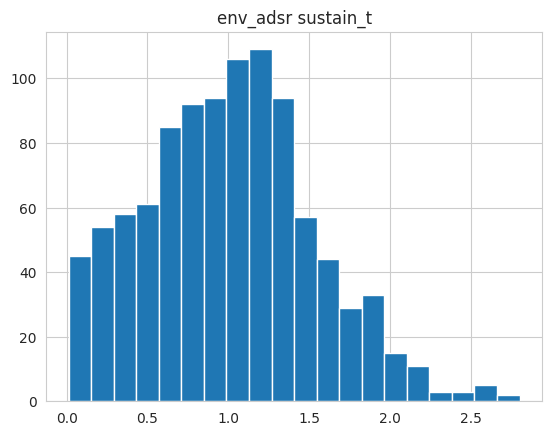

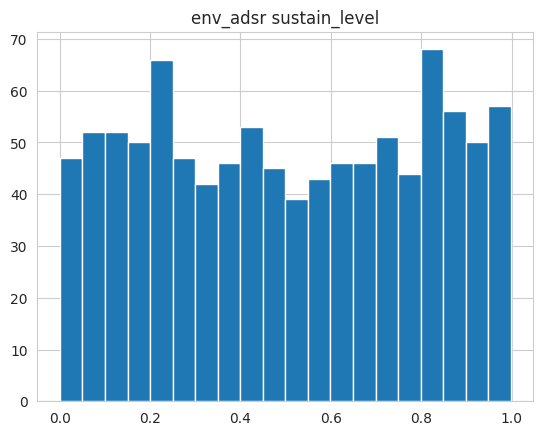

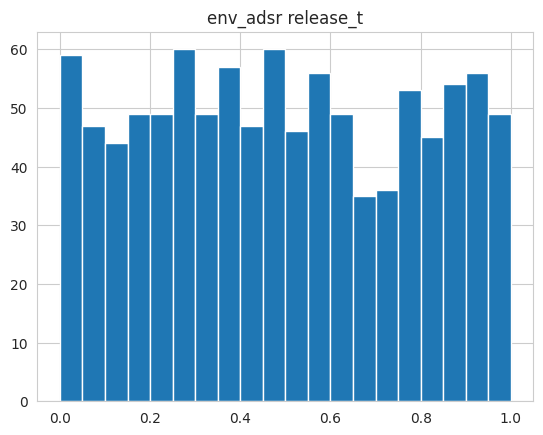

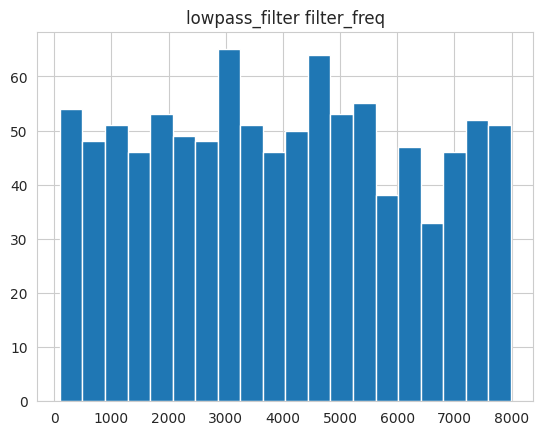

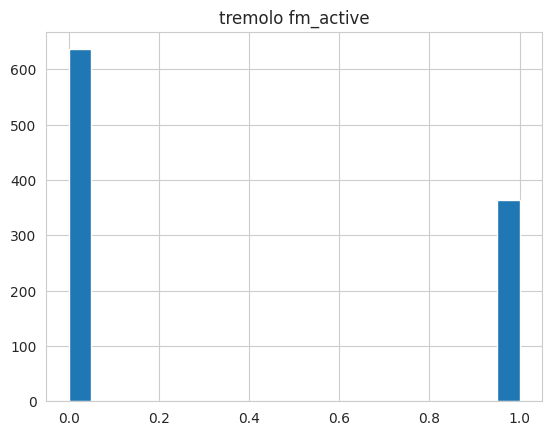

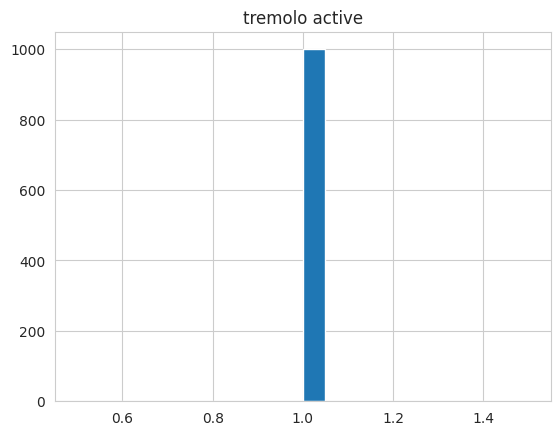

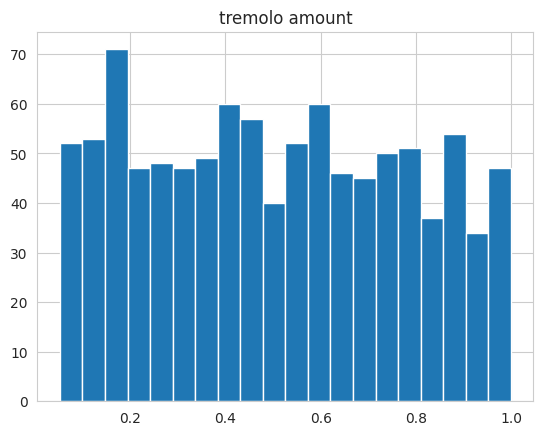

In [28]:
for col in dataset_params_df.columns:
    vals = dataset_params_df[col].values
    visualize_params(vals)

## Visualize specific sounds

In [29]:
import torchaudio

from IPython.display import Audio, display

from pprint import PrettyPrinter
printer = PrettyPrinter()

spectrogram_op = torchaudio.transforms.Spectrogram(n_fft=256)
db_op = torchaudio.transforms.AmplitudeToDB()

wav_files_dir = os.path.join(dataset_dir, split, 'wav_files')

In [30]:
def get_params_dict_from_df(df: pd.DataFrame, idx: int):

    row = df.loc[idx]
    params_dict = row.to_dict()

    filtered_dict = {}
    for k, v in params_dict.items():

        if type(v) == str:
            continue

        if isinstance(v, dict):
            if v['operation'] == 'None':
                continue

            filtered_dict[k] = v

    return filtered_dict

{(0, 0): {'operation': 'lfo_sine',
          'parameters': {'active': False, 'freq': 0.0, 'output': [(-1, -1)]}},
 (0, 2): {'operation': 'fm_sine',
          'parameters': {'active': True,
                         'amp_c': 0.8148123690902126,
                         'fm_active': False,
                         'freq_c': 1760.0000000000016,
                         'mod_index': 0.0}},
 (0, 4): {'operation': 'env_adsr',
          'parameters': {'attack_t': 0.9885313092320749,
                         'decay_t': 1.0182804290716634,
                         'release_t': 0.11533851591754629,
                         'sustain_level': 0.313707578405545,
                         'sustain_t': 0.993188261696262}},
 (0, 5): {'operation': 'lowpass_filter',
          'parameters': {'filter_freq': 3955.0268688882798}},
 (0, 6): {'operation': 'tremolo',
          'parameters': {'active': True,
                         'amount': 0.7477966606152174,
                         'fm_active': False}},
 (1, 

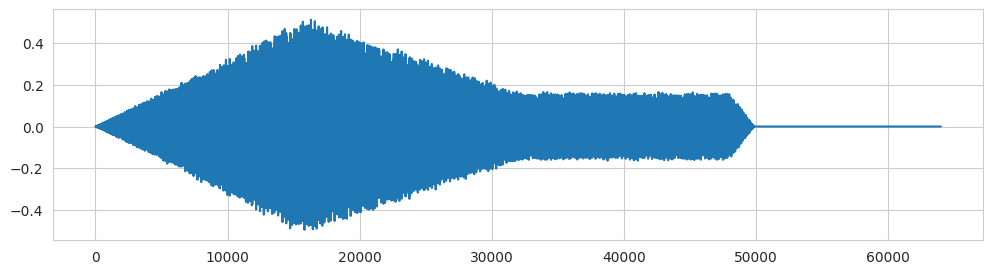

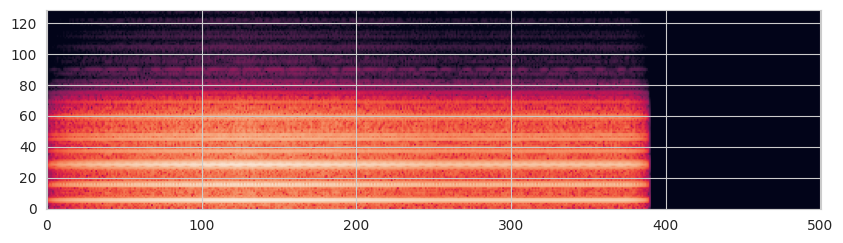

In [34]:
idx = 8
params = get_params_dict_from_df(dataset_params_df, idx)
printer.pprint(params)

wav_file_path = os.path.join(wav_files_dir, f'sound_{idx}.wav')
signal, _ = torchaudio.load(wav_file_path)

spec = db_op(spectrogram_op(signal)).numpy().squeeze()

audio = Audio(signal.numpy().squeeze(), rate=16000, autoplay=False)
display(audio)

fig, ax = plt.subplots(1, 1, figsize=(12, 3))
ax.plot(signal.numpy().squeeze())

fig2, ax2 = plt.subplots(1, 1, figsize=(10, 3))
ax2.imshow(spec, origin='lower')
plt.show()